# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning I</font>

# Exercício

# Construindo Modelo Perceptron com Numpy e TensorFlow

In [1]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhuma passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf.

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.__version__

'1.17.2'

In [4]:
tf.__version__

'2.1.0'

## Preparando o Dataset

- Carrega o dataset de um arquivo com colunas separadas por tab
- O dataset contém 3 colunas: feature 1, feature 2 e classe (labels)
- O dataset contém 100 entradas ordenadas por classe labels, 50 exemplos de cada classe

In [5]:
data = np.genfromtxt('dataset.txt', delimiter = '\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Contagem de cada classe label:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

Contagem de cada classe label: [50 50]
X.shape: (100, 2)
y.shape: (100,)


In [6]:
print(X)

[[ 0.77 -1.14]
 [-0.33  1.44]
 [ 0.91 -3.07]
 [-0.37 -1.91]
 [-1.84 -1.13]
 [-1.5   0.34]
 [-0.63 -1.53]
 [-1.08 -1.23]
 [ 0.39 -1.99]
 [-1.26 -2.9 ]
 [-5.27 -0.78]
 [-0.49 -2.74]
 [ 1.48 -3.74]
 [-1.64 -1.96]
 [ 0.45  0.36]
 [-1.48 -1.17]
 [-2.94 -4.47]
 [-2.19 -1.48]
 [ 0.02 -0.02]
 [-2.24 -2.12]
 [-3.17 -3.69]
 [-4.09  1.03]
 [-2.41 -2.31]
 [-3.45 -0.61]
 [-3.96 -2.  ]
 [-2.95 -1.16]
 [-2.42 -3.35]
 [-1.74 -1.1 ]
 [-1.61 -1.28]
 [-2.59 -2.21]
 [-2.64 -2.2 ]
 [-2.84 -4.12]
 [-1.45 -2.26]
 [-3.98 -1.05]
 [-2.97 -1.63]
 [-0.68 -1.52]
 [-0.1  -3.43]
 [-1.14 -2.66]
 [-2.92 -2.51]
 [-2.14 -1.62]
 [-3.33 -0.44]
 [-1.05 -3.85]
 [ 0.38  0.95]
 [-0.05 -1.95]
 [-3.2  -0.22]
 [-2.26  0.01]
 [-1.41 -0.33]
 [-1.2  -0.71]
 [-1.69  0.8 ]
 [-1.52 -1.14]
 [ 3.88  0.65]
 [ 0.73  2.97]
 [ 0.83  3.94]
 [ 1.59  1.25]
 [ 3.92  3.48]
 [ 3.87  2.91]
 [ 1.14  3.91]
 [ 1.73  2.8 ]
 [ 2.95  1.84]
 [ 2.61  2.92]
 [ 2.38  0.9 ]
 [ 2.3   3.33]
 [ 1.31  1.85]
 [ 1.56  3.85]
 [ 2.67  2.41]
 [ 1.23  2.54]
 [ 1.33  2

In [7]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


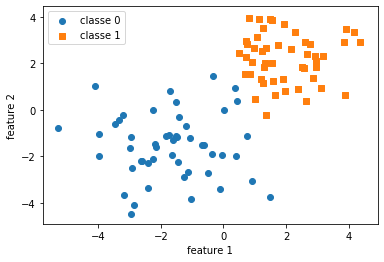

In [8]:
plt.scatter(X[y==0, 0], X[y==0, 1], label='classe 0', marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], label='classe 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Pré-processando o Dataset

- Organiza o dataset de forma aleatória
- Divide o dataset em 70% treinamento e 30% teste
- Seed random para garantir a reproducibilidade

In [9]:
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

In [10]:
X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

- Padroniza os datasets de treino e de teste (média zero e desvio padrão)

In [11]:
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

- Verifica o dataset após o pré-processamento

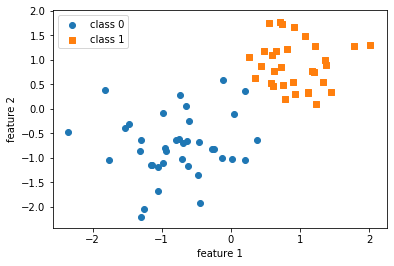

In [12]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Implementando o Perceptron com NumPy

In [13]:
def perceptron_train(features, targets, mparams=None,
                     zero_weights=True, learning_rate=1., seed=None):
    """Função de treinamento Perceptron para labels de classe binária

    Parâmetros
    ----------
    features : numpy.ndarray, shape=(n_samples, m_features)
        Uma matriz NumPy 2D contendo os exemplos de treinamento

    targets : numpy.ndarray, shape=(n_samples,)
        Uma matriz NumPy 1D contendo os labels de classe verdadeira (valores observados)

    mparams : dict or None (default: None)
        Um dicionário contendo os parâmetros do modelo, como retornado por esta função.
        Se Nenhum, um novo parâmetro do modelo é inicializado.
        Observe que os valores em mparams são atualizados no local se um mparams dict for fornecido.

    zero_weights : bool (default: True)
        Inicializa pesos com valores iguais a zeros, caso contrário os pesos do modelo são
        inicializados em pequeno número aleatório de uma distribuição normal
        com zero de média e desvio padrão 0,1.

    learning_rate : float (default: 1.0)
        Uma taxa de aprendizado para as atualizações de parâmetros. Note que uma taxa de aprendizado
        não tem efeito na direção do limite de decisão se os pesos do modelo forem inicializados com zeros.

    seed : int or None (default: None)
       Sementes para o gerador de números pseudo-aleatórios que inicializa os
       pesos se zero_weights = Falso

    Retornos
    -------
    mparams : dict
       Os parâmetros do modelo depois de treinar o perceptron por uma epoch.
       O dicionário mparams tem a forma:
        {'weights': np.array([weight_1, weight_2, ... , weight_m]),
         'bias': np.array([bias])}

    """
    # Inicializa os parâmetros do modelo
    if mparams is None:
        mparams = {'bias': np.zeros(1)}
        if zero_weights:
            mparams['weights'] = np.zeros(features.shape[1])
        else:
            rng = np.random.RandomState(seed)
            mparams['weights'] = rng.normal(loc=0.0, scale=0.1, size=(features.shape[1]))

    # Treina uma epoch
    for training_example, true_label in zip(features, targets):
        linear = np.dot(training_example, mparams['weights']) + mparams['bias']

        # Se a classe 1 foi predita, mas o label verdadeiro é 0
        if linear > 0. and not true_label:
            mparams['weights'] -= learning_rate * training_example
            mparams['bias'] -= learning_rate * 1.

        # Se a classe 0 foi predita, mas o label verdadeiro é 1
        elif linear <= 0. and true_label:
            mparams['weights'] += learning_rate * training_example
            mparams['bias'] += learning_rate * 1.

    return mparams

- Treina o modelo Perceptron com 2 epochs

In [14]:
model_params = perceptron_train(X_train, y_train, mparams=None, zero_weights=True)

for _ in range(2):
    _ = perceptron_train(X_train, y_train, mparams=model_params)

- Implementar uma função para previsões de perceptron em NumPy

In [15]:
def perceptron_predict(features, mparams):
    """Função de previsão Perceptron para labels de classe

    Parâmetros
    ----------
    features : numpy.ndarray, shape=(n_samples, m_features)
        Uma matriz NumPy 2D contendo os exemplos de treinamento

    mparams : dict
        Os parâmetros do modelo perceptron na forma:
        {'weights': np.array([weight_1, weight_2, ... , weight_m]),
         'bias': np.array([bias])}

    Retorno
    -------
    predicted_labels : np.ndarray, shape=(n_samples)
        NumPy array contendo os labels de classe previstos.

    """
    linear = np.dot(features, mparams['weights']) + mparams['bias']
    predicted_labels = np.where(linear.reshape(-1) > 0., 1, 0)
    return predicted_labels

- Calcula o erro de treinamento e teste

In [16]:
train_errors = np.sum(perceptron_predict(X_train, model_params) != y_train)
test_errors = np.sum(perceptron_predict(X_test, model_params) != y_test)

print('Número de erros no treinamento', train_errors)
print('Número de erros no teste', test_errors)

Número de erros no treinamento 0
Número de erros no teste 2


- Visualizando o limite de decisão

Perceptron é uma função linear com limiar (threshold)

$$w_{1}x_{1} + w_{2}x_{2} + b \geq 0.$$

Podemos reorganizar esta equação da seguinte forma:

$$w_{1}x_{1} + b \geq 0 - w_{2}x_{2}$$

$$- \frac{w_{1}x_{1}}{{w_2}} - \frac{b}{w_2} \leq x_{2}$$

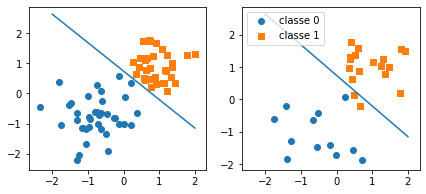

In [17]:
# Limite de Decisão (Hiperplano)
x_min = -2
y_min = ( -(model_params['weights'][0] * x_min) / model_params['weights'][1]
          -(model_params['bias'] / model_params['weights'][1]) )

x_max = 2
y_max = ( -(model_params['weights'][0] * x_max) / model_params['weights'][1]
          -(model_params['bias'] / model_params['weights'][1]) )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='classe 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='classe 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='classe 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='classe 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

- Exercícios sugeridos


1. Treine um perceptron de peso zero com diferentes taxas de aprendizagem e compare os parâmetros do modelo e os limites de decisão uns com os outros. O que você observa?

2. Repita o exercício anterior com pesos inicializados aleatoriamente.

Faça os exercícios e depois compare as respostas com as soluções propostas abaixo:

In [18]:
# %load 01_solution_weight_zero_learning_rate.py

In [19]:
# %load 02_solution_random_weights_learning_rate.py

## Implementando o Perceptron com TensorFlow

In [20]:
g = tf.Graph()


n_features = X_train.shape[1]

with g.as_default() as g:

    # Inicializando os parâmetros do modelo
    features = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_features], name='features')
    targets = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, 1], name='targets')
    params = {
        'weights': tf.Variable(tf.zeros(shape=[n_features, 1], dtype=tf.float32), name='weights'),
        'bias': tf.Variable([[0.]], dtype=tf.float32, name='bias')}

    # Forward pass
    linear = tf.matmul(features, params['weights']) + params['bias']
    ones = tf.ones(shape=tf.shape(input=linear))
    zeros = tf.zeros(shape=tf.shape(input=linear))
    prediction = tf.compat.v1.where(tf.less(linear, 0.), zeros, ones, name='prediction')

    # Atualização dos pesos
    diff = targets - prediction
    weight_update = tf.compat.v1.assign_add(params['weights'], tf.reshape(diff * features, (n_features, 1)))
    bias_update = tf.compat.v1.assign_add(params['bias'], diff)

    saver = tf.compat.v1.train.Saver()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


- Treinando o Perceptron com 5 amostras de treinamento para fins ilustrativos

In [21]:
with tf.compat.v1.Session(graph=g) as sess:

    sess.run(tf.compat.v1.global_variables_initializer())

    i = 0
    for example, target in zip(X_train, y_train):
        feed_dict = {features: example.reshape(-1, n_features),
                     targets: target.reshape(-1, 1)}
        _, _ = sess.run([weight_update, bias_update], feed_dict=feed_dict)

        i += 1
        if i >= 4:
            break


    modelparams = sess.run(params)
    print('Parâmetros do modelo:\n', modelparams)

    saver.save(sess, save_path='./perceptron')

    pred = sess.run(prediction, feed_dict={features: X_train})
    errors = np.sum(pred.reshape(-1) != y_train)
    print('Número de erros de treinamento:', errors)

Parâmetros do modelo:
 {'weights': array([[1.4725705 ],
       [0.30436274]], dtype=float32), 'bias': array([[-1.]], dtype=float32)}
Número de erros de treinamento: 3


- Continue a treinar o grafo depois de restaurar a sessão a partir de um ponto de controle local (isso pode ser útil se tivermos que interromper a sessão computacional)
- Agora treine uma época completa

In [22]:
with tf.compat.v1.Session(graph=g) as sess:
    saver.restore(sess, os.path.abspath('perceptron'))

    for epoch in range(1):
        for example, target in zip(X_train, y_train):
            feed_dict = {features: example.reshape(-1, n_features), targets: target.reshape(-1, 1)}
            _, _ = sess.run([weight_update, bias_update], feed_dict=feed_dict)
            modelparams = sess.run(params)

    saver.save(sess, save_path='./perceptron')

    pred = sess.run(prediction, feed_dict={features: X_train})
    train_errors = np.sum(pred.reshape(-1) != y_train)
    pred = sess.run(prediction, feed_dict={features: X_train})
    test_errors = np.sum(pred.reshape(-1) != y_train)

    print('Número de erros de treinamento', train_errors)
    print('Número de erros de teste', test_errors)

INFO:tensorflow:Restoring parameters from /Users/dmpm/Dropbox/DSA/DeepLearningI2.0/Cap04/Exercicios/Exercicio4/perceptron
Número de erros de treinamento 0
Número de erros de teste 0


- Exercícios sugeridos


3. Traçar o limite de decisão para este perceptron TensorFlow. Por que você acha que a implementação do TensorFlow é melhor do que a implementação do NumPy no conjunto de testes?
  - Dica 1: você pode reutilizar o código que usamos na seção NumPy
  - Dica 2: uma vez que o bias é uma matriz 2D, você precisa acessar o valor através de `modelparams ['bias'] [0]`

In [23]:
# %load 03_solution_tensorflow-boundary.py

- Vamos restaurar a sessão a partir de um meta grafico (aviso "` tf.Session () `")
- Primeiro, devemos carregar os conjuntos de dados novamente

In [24]:
with tf.compat.v1.Session() as sess:

    saver = tf.compat.v1.train.import_meta_graph(os.path.abspath('perceptron.meta'))
    saver.restore(sess, os.path.abspath('./perceptron'))

    pred = sess.run('prediction:0', feed_dict={'features:0': X_train})
    train_errors = np.sum(pred.reshape(-1) != y_train)
    pred = sess.run('prediction:0', feed_dict={'features:0': X_test})
    test_errors = np.sum(pred.reshape(-1) != y_test)

    print('Número de erros de treinamento', train_errors)
    print('Número de erros de teste', test_errors)

INFO:tensorflow:Restoring parameters from /Users/dmpm/Dropbox/DSA/DeepLearningI2.0/Cap04/Exercicios/Exercicio4/perceptron
Número de erros de treinamento 0
Número de erros de teste 0


# Fim